<a href="https://colab.research.google.com/github/zakynine/machine-learning/blob/main/ML_time_series_zaki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# deklarasi library 
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-01 00:00:00        0.0  -21 -11.0  1021.0      NW     1.79     0     0
2010-01-01 01:00:00        0.0  -21 -12.0  1020.0      NW     4.92     0     0
2010-01-01 02:00:00        0.0  -21 -11.0  1019.0      NW     6.71     0     0
2010-01-01 03:00:00        0.0  -21 -14.0  1019.0      NW     9.84     0     0
2010-01-01 04:00:00        0.0  -20 -12.0  1018.0      NW    12.97     0     0


In [ ]:
dataset = dataset.drop(columns=['pollution',
                                'dew',
                                'press',
                                'wnd_dir',
                                'wnd_spd',
                                'snow',
                                'rain',])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    43824 non-null  float64
dtypes: float64(1)
memory usage: 684.8 KB


In [ ]:
dataset.head()

,temp
date,
2010-01-01 00:00:00,-11.0
2010-01-01 01:00:00,-12.0
2010-01-01 02:00:00,-11.0
2010-01-01 03:00:00,-14.0
2010-01-01 04:00:00,-12.0


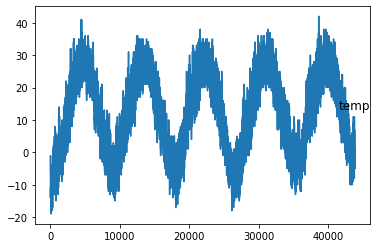

In [ ]:
values = dataset.values
# specify columns to plot
pyplot.figure()
pyplot.plot(values)
pyplot.title('temp', y=0.5, loc='right')
pyplot.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# integer encode direction
encoder = LabelEncoder()
values = encoder.fit_transform(values)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.126984  0.111111
2   0.111111  0.126984
3   0.126984  0.079365
4   0.079365  0.111111
5   0.111111  0.142857


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43823 entries, 1 to 43823
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  43823 non-null  float32
 1   var1(t)    43823 non-null  float32
dtypes: float32(2)
memory usage: 684.7 KB


In [ ]:
values = reframed.values
# count 20% for test set (dataset rows total = 5 tahun x 24 jam)
count_train = 365 * 96
# split into train and test sets
n_train_hours = count_train 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 1) (35040,) (8783, 1, 1) (8783,)


In [ ]:
#membuat class callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nmae sudah tercapai dibawah 10%")
      self.model.stop_training = True
callback = myCallback()

Epoch 1/150
487/487 - 4s - loss: 0.3857 - mae: 0.3857 - val_loss: 0.2572 - val_mae: 0.2572
Epoch 2/150
487/487 - 1s - loss: 0.1631 - mae: 0.1631 - val_loss: 0.1112 - val_mae: 0.1112
Epoch 3/150
487/487 - 1s - loss: 0.1114 - mae: 0.1114 - val_loss: 0.0911 - val_mae: 0.0911
Epoch 4/150
487/487 - 1s - loss: 0.0981 - mae: 0.0981 - val_loss: 0.0807 - val_mae: 0.0807

mae sudah tercapai dibawah 10%


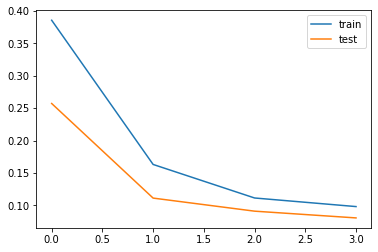

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)
model.compile(loss='mae', 
              optimizer=optimizer,
              metrics=['mae'])

# fit network
history = model.fit(train_X, 
                    train_y, 
                    epochs=150, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False,
                    callbacks=[callback])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

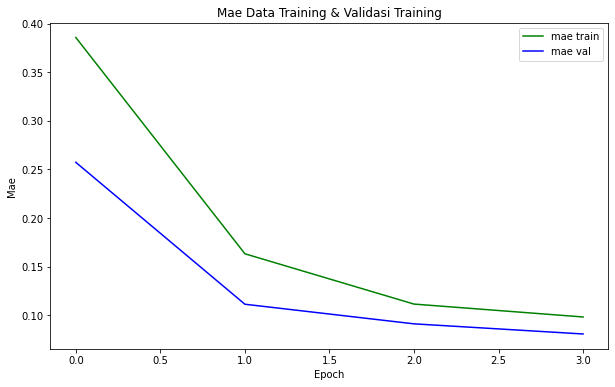

In [ ]:
#melakukan plot grafik mae
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(history.history['mae'], 'g', label='mae train')
plt.plot(history.history['val_mae'], 'b', label='mae val')
plt.xlabel('Epoch')
plt.ylabel('Mae')
plt.title('Mae Data Training & Validasi Training')
plt.legend(loc='upper right')
plt.show()

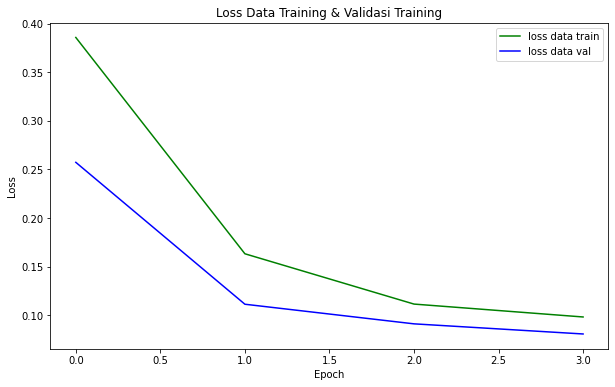

In [ ]:
#melakukan plot grafik loss
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'g', label='loss data train')
plt.plot(history.history['val_loss'], 'b', label='loss data val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Data Training & Validasi Training')
plt.legend(loc='upper right')
plt.show()